# Cell classification neural network model

## 1. Import Libraries and Set Seed

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
from skimage.feature import graycomatrix, graycoprops
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## 2. Image Processing Functions

In [2]:
# Function to validate if the image is valid
def validate_image(image):
    if image is None:
        raise ValueError("The input image is None.")

# Function 1: Binary Thresholding (Inverted)
def apply_binary_threshold(image, threshold_value=80):
    _, thresholded_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    return thresholded_image

# Function 2: Calculate Contrast using GLCM
def calculate_contrast(grayscale_image):
    glcm = graycomatrix(grayscale_image, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    return contrast

# Function 3: Count Pixels in the region of interest
def count_pixels(binary_image):
    return np.sum(binary_image == 255)

# Function to process a single image and extract features
def process_image(image, gray_image):
    validate_image(image)
    validate_image(gray_image)
    binary_image = apply_binary_threshold(gray_image)
    contrast = calculate_contrast(gray_image)
    pixel_count = count_pixels(binary_image)
    return {"Contrast": contrast, "Pixel Count": pixel_count}

## 3. Feature Extraction and Data Loading Function

In [3]:
# Function to extract features from all images in a directory and assign labels
def extract_features_and_labels(directory, label):
    features = []
    labels = []
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory {directory} does not exist.")
    for image_name in sorted(os.listdir(directory)):
        image_path = os.path.join(directory, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features_dict = process_image(img, gray_img)
        feature_vector = [features_dict['Contrast'], features_dict['Pixel Count']]
        features.append(feature_vector)
        labels.append(label)
    return features, labels

## 4. Data Visualization Functions

In [4]:
# Function to visualize processed images by rows for each category
def visualize_processed_images_by_rows(basophil_image_paths, erythroblast_image_paths, num_images):
    plt.figure(figsize=(15, 6))  # Adjust figure size based on the number of images
    # Plot basophil images in the first row
    for i, image_path in enumerate(basophil_image_paths):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        thresholded_img = apply_binary_threshold(img)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(thresholded_img, cmap='gray')
        plt.title('Basophil')
        plt.axis('off')
    # Plot erythroblast images in the second row
    for i, image_path in enumerate(erythroblast_image_paths):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        thresholded_img = apply_binary_threshold(img)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(thresholded_img, cmap='gray')
        plt.title('Erythroblast')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to create a DataFrame with extracted features and labels
def create_dataframe(X, y, columns):
    df = pd.DataFrame(X, columns=columns)
    df['Label'] = y
    df['Label'] = df['Label'].map({0: 'Basophil', 1: 'Erythroblast'})
    return df

# Scatter plot between 'Pixel Count' and 'Contrast'
def plot_scatter(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Contrast', y='Pixel Count', hue='Label', palette='coolwarm')
    plt.title('Scatter plot of Contrast vs Pixel Count')
    plt.xlabel('Contrast')
    plt.ylabel('Pixel Count')
    plt.show()

# Function to select random images from a directory
def select_random_images(directory, num_images=10):
    all_images = sorted(os.listdir(directory))
    selected_images = random.sample(all_images, min(num_images, len(all_images)))
    image_paths = [os.path.join(directory, img) for img in selected_images]
    return image_paths

## 5. Data Loading and Preprocessing

In [5]:
# Project directories
base_dir = os.getcwd()

# Training directories
basofilos_train_dir = os.path.join(base_dir, 'data', 'Data_Cells_Train', 'Basofilos_train')
eritroblasto_train_dir = os.path.join(base_dir, 'data', 'Data_Cells_Train', 'Eritroblasto_train')

# Extract features for both training classes
basophils_features, basophils_labels = extract_features_and_labels(basofilos_train_dir, 0)
erythroblasts_features, erythroblasts_labels = extract_features_and_labels(eritroblasto_train_dir, 1)

# Combine all features and labels
X = np.array(basophils_features + erythroblasts_features)
y = np.array(basophils_labels + erythroblasts_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

# Test directories
basofilos_test_dir = os.path.join(base_dir, 'data', 'Data_Cells_Test', 'Inference', 'Basofilos_inference')
eritroblasto_test_dir = os.path.join(base_dir, 'data', 'Data_Cells_Test', 'Inference', 'Eritoblastos_inference')

# Extract test set features
basofilos_test_features, basofilos_test_labels = extract_features_and_labels(basofilos_test_dir, 0)
erythroblasto_test_features, erythroblasto_test_labels = extract_features_and_labels(eritroblasto_test_dir, 1)

# Combine the test features and labels
X_test = np.array(basofilos_test_features + erythroblasto_test_features)
y_test = np.array(basofilos_test_labels + erythroblasto_test_labels)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 6. Visualizing Random Processed Images

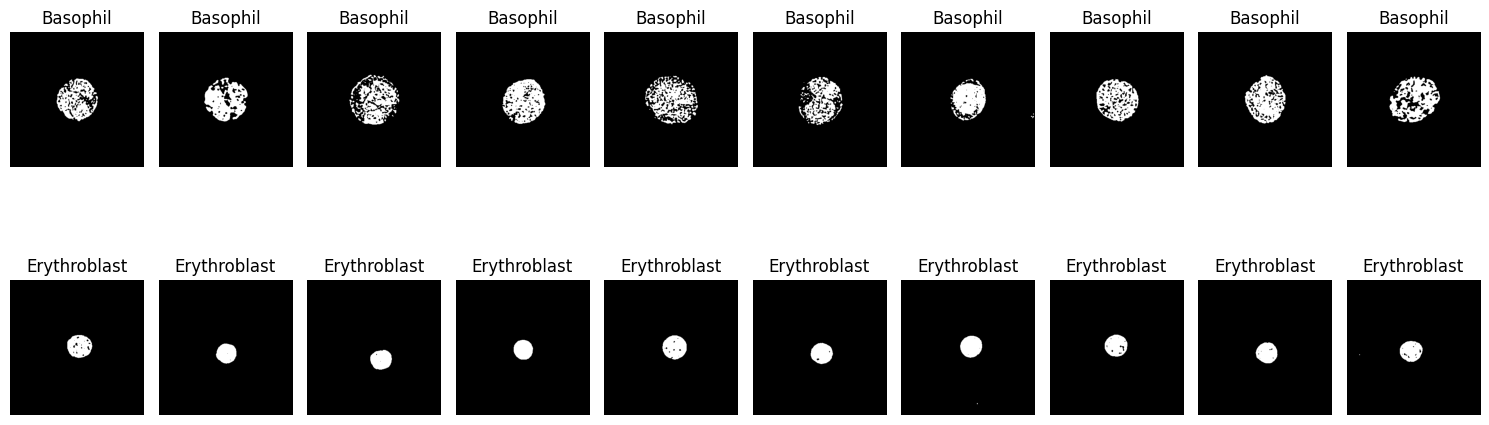

In [6]:
# Select random images from Basophils and Erythroblasts directories
random_basophil_images = select_random_images(basofilos_train_dir, num_images=10)
random_erythroblast_images = select_random_images(eritroblasto_train_dir, num_images=10)

# Visualize random processed images (10 from each category, in two rows)
visualize_processed_images_by_rows(random_basophil_images, random_erythroblast_images, num_images=10)

## 7. Data Visualization: DataFrame and Scatter Plot

Training DataFrame:
    Contrast  Pixel Count         Label
0   0.175252     0.614358      Basophil
1   0.402801     0.499863      Basophil
2   3.151634     1.521370      Basophil
3  -0.957752    -0.820761  Erythroblast
4  -0.776122    -0.877651  Erythroblast
5  -0.931351    -0.837936  Erythroblast
6   0.728449     1.081997      Basophil
7  -0.706833    -0.949210  Erythroblast
8  -0.114658     1.420114      Basophil
9  -0.891895    -0.924164  Erythroblast
10  1.077901     1.637296      Basophil
11 -0.640676    -1.095549  Erythroblast
12  1.513086     1.078061      Basophil
13 -0.045867     0.640477      Basophil
14 -0.786859    -1.231511  Erythroblast
15  0.992707     0.609349      Basophil
16  0.620625     0.556395      Basophil
17  0.609888     0.933154      Basophil
18 -0.961021    -1.081595  Erythroblast
19  2.259901     1.398646      Basophil


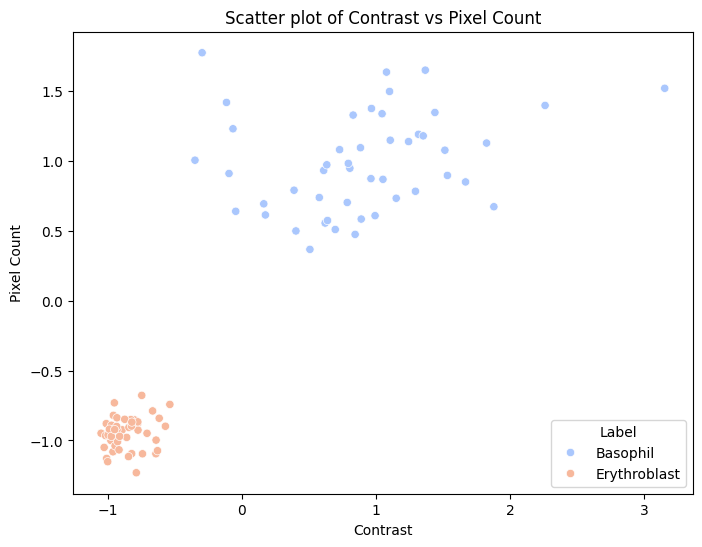

In [7]:
# Create and display the DataFrame of extracted features
df_train = create_dataframe(X_train_scaled, y_train, columns=["Contrast", "Pixel Count"])
print("Training DataFrame:")
print(df_train.head(20))

# Scatter plot of contrast vs pixel count
plot_scatter(df_train)

## 8. Neural Network Model Definition and Training

In [8]:
# Define the neural network model with regularization and dropout
model = tf.keras.Sequential([
    # Input layer for 2 features: contrast and pixel count
    tf.keras.layers.Input(shape=(2,)),  
    
    # First hidden layer with 16 neurons, ReLU activation, and L2 regularization
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    
    # Dropout layer
    Dropout(0.2, seed=seed),
    
    # Second hidden layer with 8 neurons, ReLU activation, and L2 regularization
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), 
                    batch_size=8, callbacks=[early_stopping])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4553 - loss: 0.7492 - val_accuracy: 0.5417 - val_loss: 0.7010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6141 - loss: 0.6928 - val_accuracy: 0.7500 - val_loss: 0.6475
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7628 - loss: 0.6342 - val_accuracy: 1.0000 - val_loss: 0.5947
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9189 - loss: 0.5782 - val_accuracy: 1.0000 - val_loss: 0.5381
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9605 - loss: 0.5210 - val_accuracy: 1.0000 - val_loss: 0.4821
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.4640 - val_accuracy: 1.0000 - val_loss: 0.4287
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.4375 - val_accuracy: 1.0000 - val_loss: 0.3774
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.3710 - val_accuracy: 1.0000 - 

## 9. Performance Evaluation

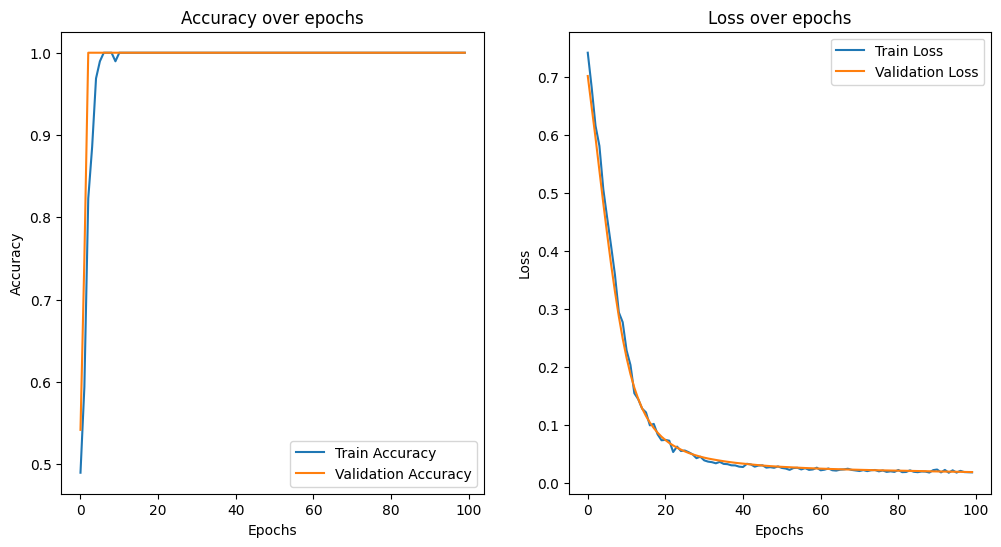

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 1.0000 - loss: 0.0171
Test Loss: 0.0171
Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


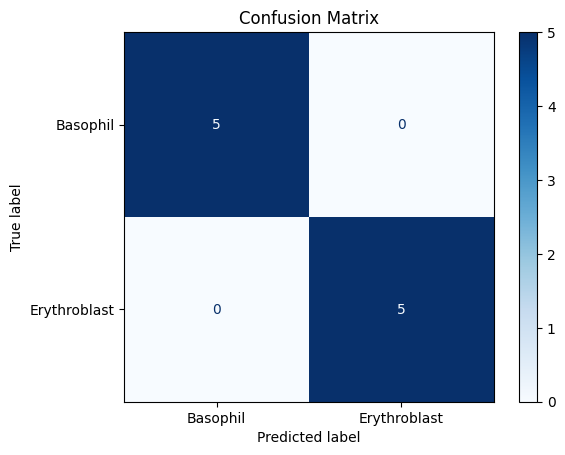

In [9]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the trained model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Basophil", "Erythroblast"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()